In [1]:
# Importing all the required libraries
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


In [28]:
df = pd.read_csv("telco_churn_cleaned.csv") 
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\ndtypes:\n", df.dtypes.head(10))
print("\nTarget (raw):", df['Churn'].value_counts(dropna=False).to_dict())
display(df.head(3))


Shape: (7032, 31)

Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Churn']

dtypes:
 gender                              int64
SeniorCitizen                       int64
Partner                             int64
Dependents                          int64
tenure                              int64
Phone

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,1,0,1,0,1,29.85,29.85,True,...,False,False,False,False,False,False,False,True,False,0
1,1,0,0,0,34,1,0,56.95,1889.50,False,...,False,False,False,False,True,False,False,False,True,0
2,1,0,0,0,2,1,1,53.85,108.15,False,...,False,False,False,False,False,False,False,False,True,1


In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int64  
 1   SeniorCitizen                          7032 non-null   int64  
 2   Partner                                7032 non-null   int64  
 3   Dependents                             7032 non-null   int64  
 4   tenure                                 7032 non-null   int64  
 5   PhoneService                           7032 non-null   int64  
 6   PaperlessBilling                       7032 non-null   int64  
 7   MonthlyCharges                         7032 non-null   float64
 8   TotalCharges                           7032 non-null   float64
 9   MultipleLines_No phone service         7032 non-null   bool   
 10  MultipleLines_Yes                      7032 non-null   bool   
 11  Inte

In [27]:
# Cleaning the data
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# Drop non-predictive ID if present
for id_col in ['customerID', 'CustomerID', 'customerId']:
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)
        
# Ensure binary text columns become 0/1 if they exist
binary_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
for col in binary_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].map({'Yes':1,'No':0,'Male':1,'Female':0,'True':1,'False':0}).astype('int64')
        
# One‑hot for multi-category columns (only those present)
multi_cols = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
              'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
              'Contract','PaymentMethod']

multi_cols = [c for c in multi_cols if c in df.columns]
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

df['Churn'] = df['Churn'].astype(int)
print("After encoding:", df.shape)


After encoding: (7032, 31)


In [5]:
# Data description (summary + class balance)
desc_num = df.select_dtypes(include=['int64','float64']).describe().T
print("Numerical summary (first 12 rows):")
display(desc_num.head(12))

print("\nClass balance:")
print(df['Churn'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')


Numerical summary (first 12 rows):


,count,mean,std,min,25%,50%,75%,max
gender,7032.0,0.504693,0.500014,0.00,0.0000,1.000,1.0000,1.00
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
Partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
Dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
PhoneService,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
PaperlessBilling,7032.0,0.592719,0.491363,0.00,0.0000,1.000,1.0000,1.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80



Class balance:
Churn
0    73.42%
1    26.58%
Name: proportion, dtype: object


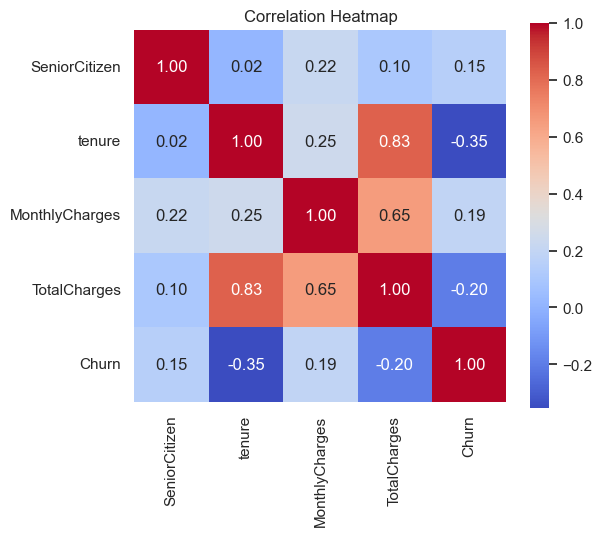

In [6]:
# Correlation heatmap for main numeric drivers
cols_for_corr = [c for c in ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','Churn'] if c in df.columns]
corr = df[cols_for_corr].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()


In [7]:
# Train/test split and using SMOTE on train only due to more imbalance
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Train before SMOTE:\n", y_train.value_counts())
print("\nTrain after SMOTE:\n", y_train_bal.value_counts())


Train before SMOTE:
 Churn
0    4130
1    1495
Name: count, dtype: int64

Train after SMOTE:
 Churn
0    4130
1    4130
Name: count, dtype: int64


In [8]:
# Train models
# Logistic Regression with simple scaling
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_bal)
X_test_lr  = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=2000, solver='lbfgs')
log_model.fit(X_train_lr, y_train_bal)

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

xgb_model = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.9, eval_metric='logloss',
    random_state=42, n_jobs=-1
)
xgb_model.fit(X_train_bal, y_train_bal)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

Logistic Regression:
               precision    recall  f1-score   support

           0      0.858     0.782     0.818      1033
           1      0.516     0.642     0.572       374

    accuracy                          0.745      1407
   macro avg      0.687     0.712     0.695      1407
weighted avg      0.767     0.745     0.753      1407

Random Forest:
               precision    recall  f1-score   support

           0      0.851     0.834     0.843      1033
           1      0.566     0.596     0.581       374

    accuracy                          0.771      1407
   macro avg      0.708     0.715     0.712      1407
weighted avg      0.775     0.771     0.773      1407

XGBoost:
               precision    recall  f1-score   support

           0      0.849     0.817     0.833      1033
           1      0.542     0.599     0.569       374

    accuracy                          0.759      1407
   macro avg      0.696     0.708     0.701      1407
weighted avg      0.768   

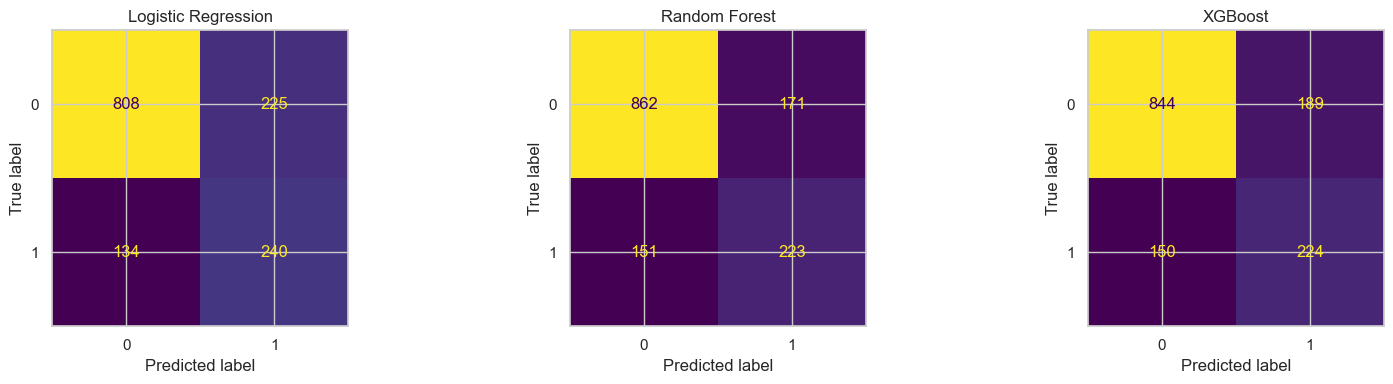

In [9]:
#Predictions, reports, confusion matrices
y_pred_lr  = log_model.predict(X_test_lr)
y_pred_rf  = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

print("Logistic Regression:\n", classification_report(y_test, y_pred_lr, digits=3))
print("Random Forest:\n", classification_report(y_test, y_pred_rf, digits=3))
print("XGBoost:\n", classification_report(y_test, y_pred_xgb, digits=3))

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, (name, y_pred) in zip(
    axes,
    [("Logistic Regression", y_pred_lr),
     ("Random Forest", y_pred_rf),
     ("XGBoost", y_pred_xgb)]
):
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.tight_layout()
plt.show()


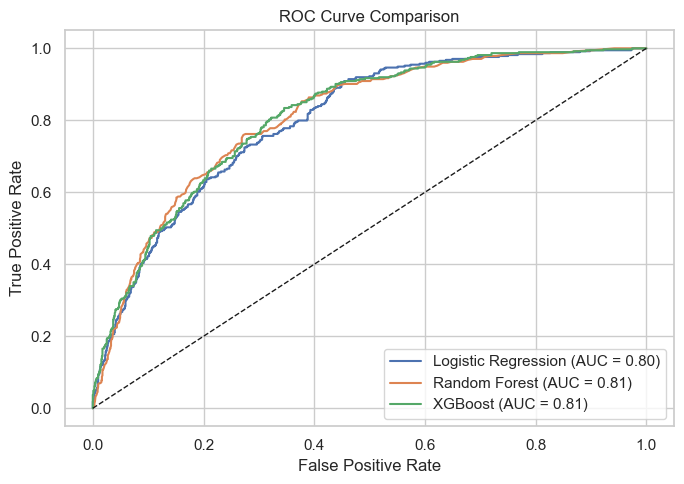

In [25]:
# ROC curves + AUC
from sklearn.metrics import roc_auc_score

y_prob_lr  = log_model.predict_proba(X_test_lr)[:,1]
y_prob_rf  = rf_model.predict_proba(X_test)[:,1]
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_prob_lr)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

auc_lr  = auc(fpr_lr, tpr_lr)
auc_rf  = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot([0,1],[0,1],'k--',linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


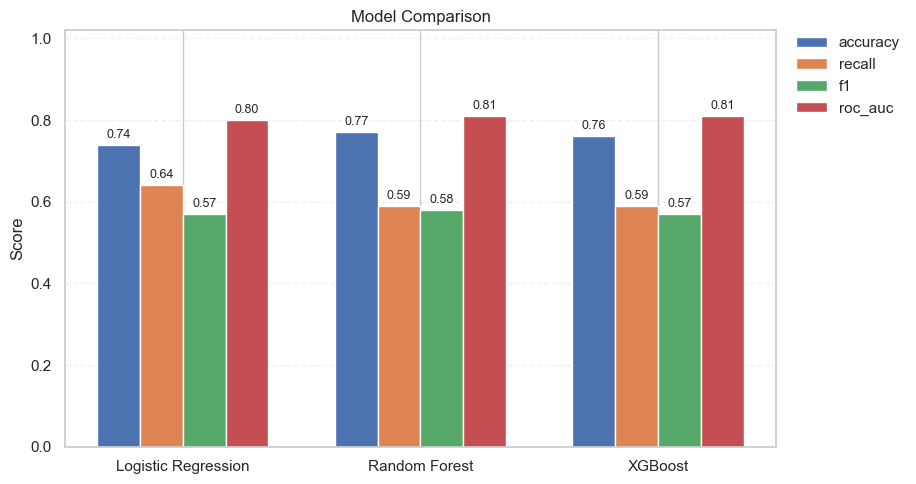

In [23]:
scores = pd.DataFrame({
    "accuracy":  [0.74, 0.77, 0.76],
    "recall":    [0.64, 0.59, 0.59],
    "f1":        [0.57, 0.58, 0.57],
    "roc_auc":   [0.80, 0.81, 0.81],
}, index=["Logistic Regression", "Random Forest", "XGBoost"])

metrics = ["accuracy", "recall", "f1", "roc_auc"]
models  = scores.index.tolist()

# Grouped bar chart
fig, ax = plt.subplots(figsize=(11, 5))
x = np.arange(len(models))
bar_w = 0.18
offsets = np.linspace(-1.5*bar_w, 1.5*bar_w, num=len(metrics))

bars = []
for i, m in enumerate(metrics):
    b = ax.bar(x + offsets[i], scores[m].values, width=bar_w, label=m)
    bars.append(b)
    # value labels
    for rect in b:
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height()+0.01,
                f"{rect.get_height():.2f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylim(0, 1.02)
ax.set_title("Model Comparison")
ax.set_ylabel("Score")
ax.grid(axis="y", linestyle="--", alpha=0.3)

leg = ax.legend(title="", loc="upper left", bbox_to_anchor=(1.02, 1),
                borderaxespad=0., frameon=False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

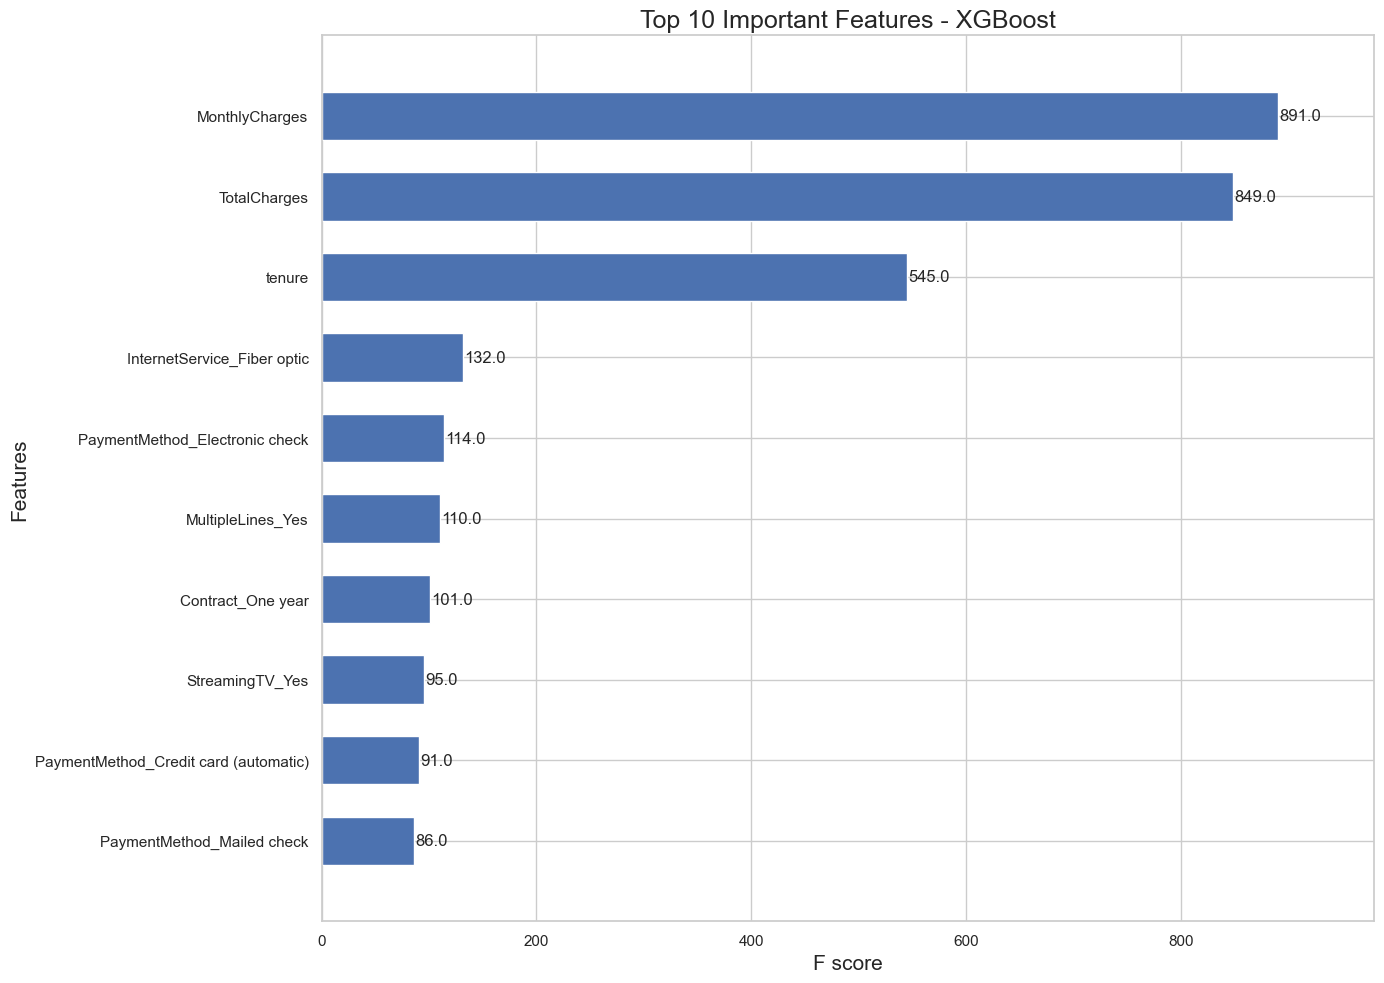

In [21]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_importance(
    xgb_model,
    ax=ax,
    max_num_features=10,
    height=0.6,
    importance_type='weight'
)
ax.set_title("Top 10 Important Features - XGBoost", fontsize=18)
ax.set_xlabel("F score", fontsize=15)
ax.set_ylabel("Features", fontsize=15)
plt.tight_layout()
plt.show()
